# Linguistics Project

#### Goal: Predict Emotions from recorded speech

In [66]:
import numpy as np
import seaborn as sns
import wave
import sys
import os
import matplotlib.pyplot as plt
from scipy import signal
import librosa
import glob
import random
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import normalize 

In [47]:
data_dir = '../data/Audio_Speech_Actors_01-24/Actor_07'
data_file = '03-01-01-01-01-01-07.wav'

data_path = os.path.join(data_dir, data_file)

In [48]:
def list_all_files(path='../data/Audio_Speech_Actors_01-24/'):
    relevant_files_regex = 'Actor_*/03-01-*.wav'
    relevant_files_list = glob.glob(path + relevant_files_regex)
    return relevant_files_list

In [61]:
#STFT https://towardsdatascience.com/audio-processing-in-tensorflow-208f1a4103aa
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    # Take segments from the signal
    nperseg = int(round(window_size * sample_rate / 1e3))
    # provides a 'smoother' spec compared to with 0 overlap
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    # Transpose spec-matrix into a 32-float array
    spectrogram = spec.astype(np.float32)
    log_spectrogram = np.log10(spectrogram + eps)
    return freqs, times, log_spectrogram

Length in Nr. of Samples: 45056


Text(0.5,0,'Seconds')

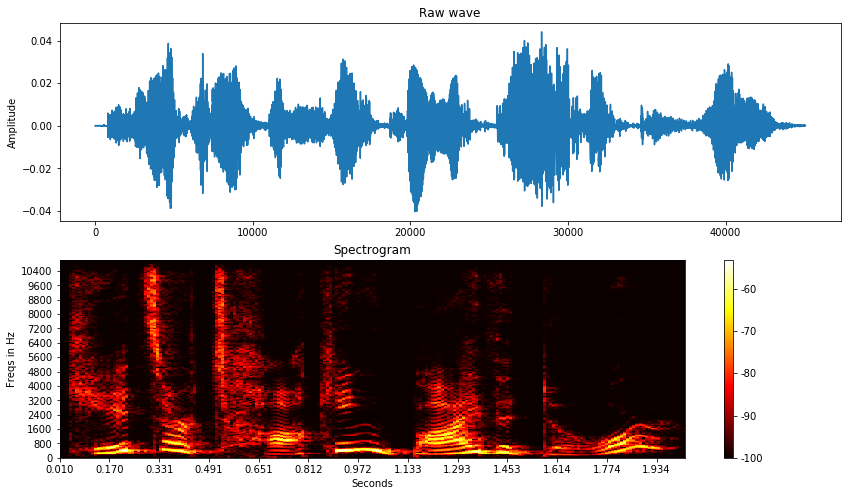

In [50]:
# Draw and plot random sample + its spectrogram

#trim all noise below 30Db at the beginning and end of time-axes
#trim one specific file

relevant_files_list = list_all_files()

raw_samples, sample_rate = librosa.load(random.choice(relevant_files_list))
samples, index = librosa.effects.trim(raw_samples, top_db=35)

freqs, times, spectrogram = log_specgram(samples, sample_rate)

print('Length in Nr. of Samples: {}'.format(len(samples)))

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave')
ax1.set_ylabel('Amplitude')
ax1.plot(samples)

ax2 = fig.add_subplot(212)
s = ax2.imshow(spectrogram, aspect='auto', cmap='hot', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
plt.colorbar(s, ax=ax2, format='%+02.0f')
ax2.set_title('Spectrogram')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

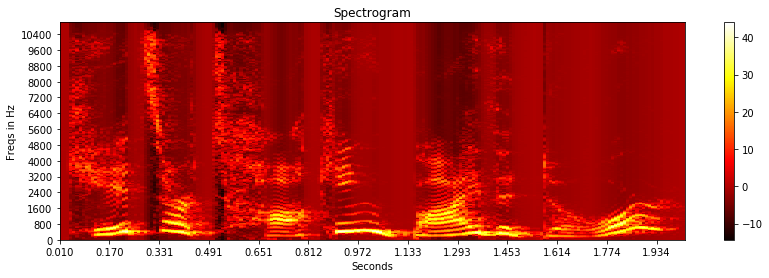

In [58]:
# mean vector
# ToDo: Axis 0 or Axis 1?

#Axis 0
feature_mean = np.mean(spectrogram, axis=0)
centered_spectrogram = spectrogram - feature_mean
#Axis 1
#feature_mean = np.mean(spectrogram, axis=1)
#centered_spectrogram = (spectrogram.T - feature_mean).T
 
plt.figure(figsize=(14,4))
s= plt.imshow(centered_spectrogram, aspect='auto', cmap='hot', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
plt.yticks(freqs[::16])
plt.xticks(times[::16])
plt.colorbar(s)
plt.title('Spectrogram')
plt.ylabel('Freqs in Hz')
plt.xlabel('Seconds')
plt.show()

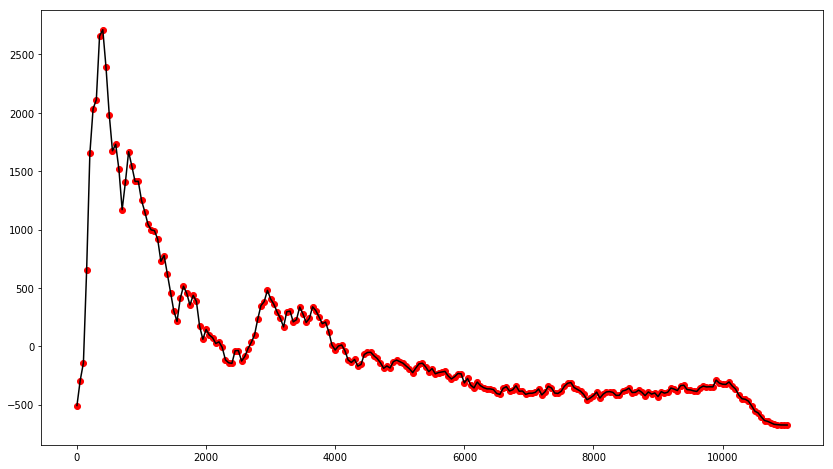

In [60]:
sum_frequ = np.sum(centered_spectrogram, axis=1)
uncentered_sum_frequ = np.sum(spectrogram, axis=1)

plt.figure(figsize=(14,8))
plt.scatter(freqs, sum_frequ, color='red')
plt.plot(freqs, sum_frequ, color='black')
plt.show()


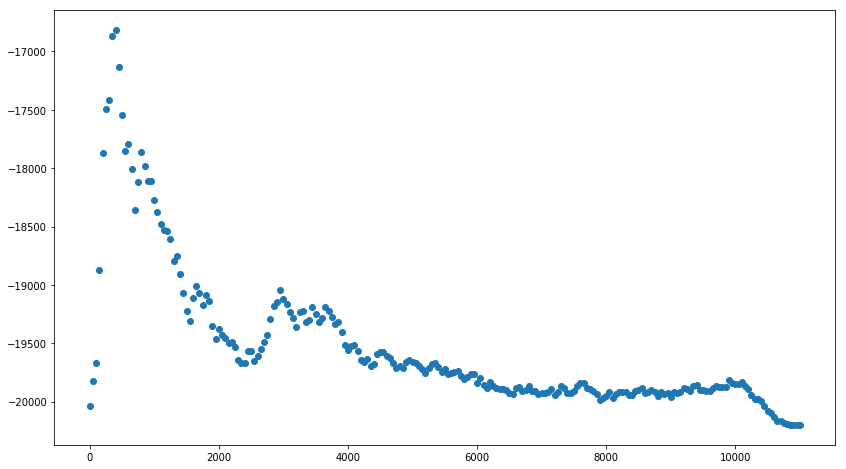

In [57]:
plt.figure(figsize=(14,8))
plt.scatter(freqs, uncentered_sum_frequ)
plt.show()

In [75]:
#center entire data set

def process_data_set():
    list_sum_frequs = []
    list_labels = []
    for i, file in enumerate(relevant_files_list, 1):
        emotion_number = int(file.split('/')[-1].split('-')[2].lstrip('0'))
        list_labels.append(emotion_number)
        
        raw_samples, sample_rate = librosa.load(file)
        samples, index = librosa.effects.trim(raw_samples, top_db=35)
        freqs, times, spectrogram = log_specgram(samples, sample_rate)
        #Axis 0
        feature_mean = np.mean(spectrogram, axis=0)
        centered_spectrogram = spectrogram - feature_mean
        
        sum_frequ = np.sum(centered_spectrogram, axis=1)
        list_sum_frequs.append(list(sum_frequ))
        
        sys.stdout.write('\riteration {}'.format(i))
        sys.stdout.flush()
    return np.asarray(list_sum_frequs), np.asarray(list_labels), np.mean(list_sum_frequs, axis=0)
        
        
        

In [76]:
#data, labels, mean = process_data_set()

#np.savez('./sum_frequ_data', data=data, labels=labels)
#np.save('./sum_frequ_mean', mean)

iteration 1440

In [77]:
try:
    dataset = np.load('./sum_frequ_data.npz')
    data_mean = np.load('./sum_frequ_mean.npy')
except:
    print('File with num_frequ_mean not found')

train_x = dataset['data']
train_y = dataset['labels']

print(train_x.shape, train_y.shape, data_mean.shape)

(1440, 221) (1440,) (221,)


In [ ]:
S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
#librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.imshow(log_S, cmap='hot')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

In [ ]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
#librosa.display.specshow(delta2_mfcc)
plt.imshow(delta2_mfcc, cmap='hot')
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()